# 계층적 군집

**Hierarchical Clustering**

## #01. 패키지

모델 : scipy.cluster.AgglomerativeClustering

거리계산 : scipy.cluster.hierarchy.linkage

시각화 : scipy.cluster.hierarchy.dendrogram

평가 : sklearn.metrics.silhouette_score , silhouette_samples, yellowbrick.cluster.KElbowVisualizer

In [1]:
import sys
import seaborn as sb
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from pandas import read_excel, DataFrame

# sklearn은 AgglomerativeClustering() 함수를 제공
from sklearn.cluster import AgglomerativeClustering

# 표준화
from sklearn.preprocessing import MinMaxScaler

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

## #02. 데이터

In [3]:
origin = read_excel("행정동병합최종.xlsx")
origin.head()

,시도명,시군구코드,시군구명,행정동코드,행정동코드_수정,읍면동명,생성일자,말소일자,지하철역_수,의료기관_수,...,보육시설수,세대당공원면적minmax,수변점수,행정동별버스정류장수,행정동별유통업체수,공공자전거대여소수,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,그린지수minmax
0,서울특별시,11110,종로구,1111051500,11110515,청운효자동,20081101,0,0,11,...,4,0.352898,0,32,0,3,0.038298,0.120179,0.035322,0.187151
1,서울특별시,11110,종로구,1111053000,11110530,사직동,19880423,0,2,75,...,0,0.063554,0,27,0,12,0.093504,0.033721,0.131414,0.033704
2,서울특별시,11110,종로구,1111054000,11110540,삼청동,19880423,0,0,11,...,3,1.000000,0,16,0,5,0.077132,0.078692,0.040614,0.530328
3,서울특별시,11110,종로구,1111055000,11110550,부암동,19880423,0,0,4,...,3,0.000000,10,34,0,5,0.024572,0.104086,0.043385,0.530328
4,서울특별시,11110,종로구,1111056000,11110560,평창동,19880423,0,0,15,...,3,0.001192,10,54,0,5,0.007649,0.489879,0.018995,0.530960


## #03. 데이터 전처리

### 필요한 데이터만 추출

In [4]:
origin.columns

Index(['시도명', '시군구코드', '시군구명', '행정동코드', '행정동코드_수정', '읍면동명', '생성일자', '말소일자',
       '지하철역_수', '의료기관_수', '사회복지시설_수', '계(명)', '면적 (k㎡)', '구성비 (%)',
       '행정동별_공원수', '공공체육시설_수', '문화시설_수', '학교_수', '사업체_수', '개소 (공영+민영)',
       '면수 (공영+민영)', '하천및한강여부', '아동인구(0~9세)', '노인인구(65세이상)', '장애인_인구',
       '세대당공원면적', '보육시설수', '세대당공원면적minmax', '수변점수', '행정동별버스정류장수', '행정동별유통업체수',
       '공공자전거대여소수', '여가생활지수minmax', '사회적약자_지원_인프라_밀집도minmax', '접근성지수minmax',
       '그린지수minmax'],
      dtype='object')

In [5]:
df = origin.filter([
    '지하철역_수', '의료기관_수', '사회복지시설_수', '계_명', '면적', '구성비', 
    '행정동별_공원수', '공공체육시설_수', '문화시설_수', '학교_수', '사업체_수', '개소', 
    '면수', '하천및한강여부', '아동인구', '노인인구', '장애인_인구', '세대당공원면적', 
    '보육시설수', '세대당공원면적minmax', '수변점수', '행정동별버스정류장수', 
    '여가생활지수minmax', '사회적약자_지원_인프라_밀집도minmax', '접근성지수minmax', '그린지수minmax'
])
df.head()

,지하철역_수,의료기관_수,사회복지시설_수,행정동별_공원수,공공체육시설_수,문화시설_수,학교_수,사업체_수,하천및한강여부,장애인_인구,세대당공원면적,보육시설수,세대당공원면적minmax,수변점수,행정동별버스정류장수,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,그린지수minmax
0,0,11,5,2,10,6,8,992,0,437,337.55,4,0.352898,0,32,0.038298,0.120179,0.035322,0.187151
1,2,75,1,3,8,13,2,3532,0,267,60.79,0,0.063554,0,27,0.093504,0.033721,0.131414,0.033704
2,0,11,0,1,2,31,2,708,0,110,956.51,3,1.000000,0,16,0.077132,0.078692,0.040614,0.530328
3,0,4,4,1,5,5,4,558,유,311,0.00,3,0.000000,10,34,0.024572,0.104086,0.043385,0.530328
4,0,15,11,0,5,11,4,747,유,491,1.14,3,0.001192,10,54,0.007649,0.489879,0.018995,0.530960


In [6]:
df = df.fillna(0)
df.isna().sum()

지하철역_수                    0
의료기관_수                    0
사회복지시설_수                  0
행정동별_공원수                  0
공공체육시설_수                  0
문화시설_수                    0
학교_수                      0
사업체_수                     0
하천및한강여부                   0
장애인_인구                    0
세대당공원면적                   0
보육시설수                     0
세대당공원면적minmax             0
수변점수                      0
행정동별버스정류장수                0
여가생활지수minmax              0
사회적약자_지원_인프라_밀집도minmax    0
접근성지수minmax               0
그린지수minmax                0
dtype: int64

#### 분석에 사용될 지수 추출

`minmax로 scaling한 지수`를 분석에 사용

In [7]:
X = df.copy()
X = X.filter(['여가생활지수minmax', '사회적약자_지원_인프라_밀집도minmax', '접근성지수minmax', '그린지수minmax'])
X.head()

,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,그린지수minmax
0,0.038298,0.120179,0.035322,0.187151
1,0.093504,0.033721,0.131414,0.033704
2,0.077132,0.078692,0.040614,0.530328
3,0.024572,0.104086,0.043385,0.530328
4,0.007649,0.489879,0.018995,0.530960


#### 지수의 결측치 확인 및 처리

In [8]:
X.isna().sum()

여가생활지수minmax              0
사회적약자_지원_인프라_밀집도minmax    0
접근성지수minmax               0
그린지수minmax                0
dtype: int64

In [9]:
# X = X.fillna(0)
# X.isna().sum()

#### 이상치(`inf`) 유무 확인

In [10]:
is_inf = X.isin([np.inf, -np.inf])

# 각 column별로 -inf 또는 inf 값을 포함하고 있는 행 수를 확인
inf_count = is_inf.sum()

# 결과 출력
inf_count

여가생활지수minmax              0
사회적약자_지원_인프라_밀집도minmax    0
접근성지수minmax               0
그린지수minmax                0
dtype: int64

In [11]:
X.columns

Index(['여가생활지수minmax', '사회적약자_지원_인프라_밀집도minmax', '접근성지수minmax', '그린지수minmax'], dtype='object')

### 분석용 데이터 스케일링

이미 MinMax로 스케일링된 값들이므로 제외

In [12]:
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)
# X[:5]

In [13]:
ndf = DataFrame(X, columns=X.columns)
ndf.head()

,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,그린지수minmax
0,0.038298,0.120179,0.035322,0.187151
1,0.093504,0.033721,0.131414,0.033704
2,0.077132,0.078692,0.040614,0.530328
3,0.024572,0.104086,0.043385,0.530328
4,0.007649,0.489879,0.018995,0.530960


> 전원 수치 데이터임으로 별도의 라벨링이 필요 없다고 판단.

## #04. 계층 군집 수행

### 1. scipy 패키지 사용

scipy는 모델 생성/시각화 과정이 반자동이지만 sklearn은 수동으로 설정(공식으로 판단할 것)

linkage : 거리 측정 방법 지정<br/>
기본 값 : `ward`<br/>
그 외 값 : ‘ward’, ‘complete’, ‘average’, ‘single’

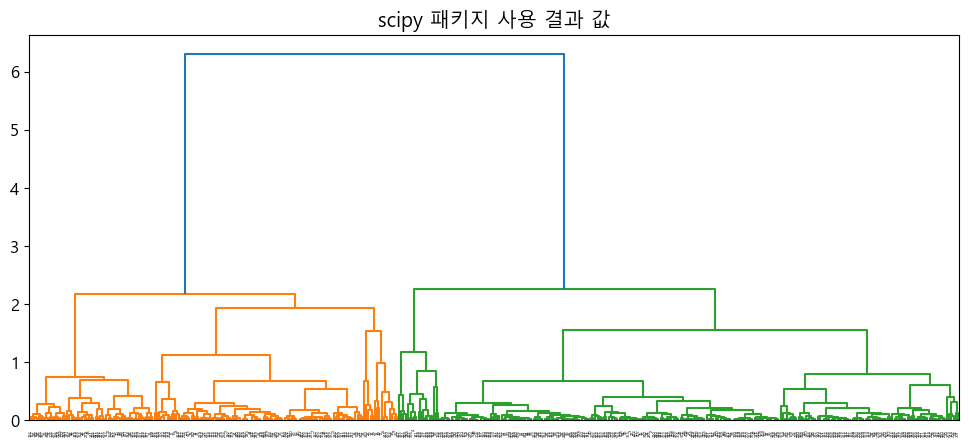

In [14]:
lnk = linkage(ndf, method="ward")
plt.figure(figsize=(12,5))
dendrogram(lnk, show_leaf_counts=True)
plt.xticks(fontsize=3)  # 원하는 글자 크기로 설정
plt.title("scipy 패키지 사용 결과 값")
plt.show()
plt.close()

### 2. sklearn 패키지 사용

n_clusters : 찾아야 할 클러스터 수(earlystopping과 유사)

affinity : 클러스터 간 거리 측정 방법(euclidean, cityblock, manhattan, cosine)

linkage : ward(기본값), complete, average, single

compute_distances : 노드간의 거리 계산값을 저장할지 여부(시각화를 위해서는 True를 필수 적용)

`n_clusters`은 K-Means에서 엘보우 그래프로 확인된 `4`, 또는 새로 설정한 `6`을 사용.

#### n_clusters=`4`

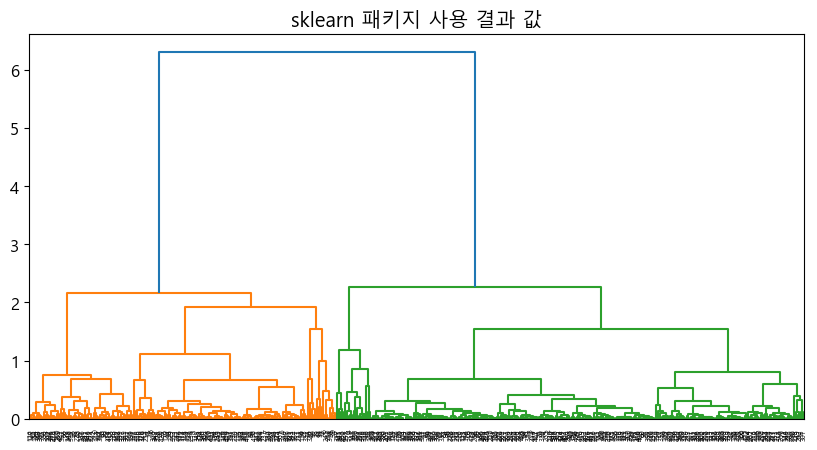

In [15]:
# 모델 객체 생성
ac = AgglomerativeClustering(n_clusters=4,  # 찾아야 할 클러스터 수(earlystopping과 유사)
                             metric='euclidean',  # 클러스터 간 거리 측정 방법
                             linkage='ward',    # 거리측정 방법
                             compute_distances=True #시각화를 위하 반드시 필요
                             )
# clustering1 = ac.fit(X) #학습

clustering1 = ac.fit(ndf) #학습
# print(clustering1.labels_)   #학습결과 확인

# scipy는 아래의 과정을 자동으로 수행, sklearn은 수동으로 설정(공식으로 판단할 것)
counts = np.zeros(clustering1.children_.shape[0])    #zeros 모든 원소가 0인 요소
n_samples = len(clustering1.labels_)

# 자식 노드를 반복하면서 점을 찍어준다(자식이 몇개 있는지 확인하는 과정)
for i, merge in enumerate(clustering1.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# 자식 노드의 수를 저장하는 배열
linkage_matrix = np.column_stack(
    [clustering1.children_, clustering1.distances_, counts]
).astype(float)

# plt를 설정하지 않으면 쓸데 없는 값도 함께 추출됨
# dendrogram(linkage_matrix)

plt.figure(figsize=(10,5))
dendrogram(linkage_matrix)
plt.title("sklearn 패키지 사용 결과 값")
plt.show()
plt.close()

##### 군집수를 `4`로 설정한 분류 결과값

In [16]:
unique_labels = list(set(clustering1.labels_))
unique_labels

[0, 1, 2, 3]

##### 분류 결과를 DataFrame과 결합

> 군집(label)을 포함한 DF 생성. <br/> labels를 hue로 잡고 진행하면 군집의 분류 결과를 알 수 있기 때문.

In [17]:
df1 = df.copy()

In [18]:
df1['계층군집_결과'] = clustering1.labels_
df1.head()

,지하철역_수,의료기관_수,사회복지시설_수,행정동별_공원수,공공체육시설_수,문화시설_수,학교_수,사업체_수,하천및한강여부,장애인_인구,세대당공원면적,보육시설수,세대당공원면적minmax,수변점수,행정동별버스정류장수,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,그린지수minmax,계층군집_결과
0,0,11,5,2,10,6,8,992,0,437,337.55,4,0.352898,0,32,0.038298,0.120179,0.035322,0.187151,3
1,2,75,1,3,8,13,2,3532,0,267,60.79,0,0.063554,0,27,0.093504,0.033721,0.131414,0.033704,0
2,0,11,0,1,2,31,2,708,0,110,956.51,3,1.000000,0,16,0.077132,0.078692,0.040614,0.530328,1
3,0,4,4,1,5,5,4,558,유,311,0.00,3,0.000000,10,34,0.024572,0.104086,0.043385,0.530328,1
4,0,15,11,0,5,11,4,747,유,491,1.14,3,0.001192,10,54,0.007649,0.489879,0.018995,0.530960,2


##### 각 지수를 기준으로 군집을 분석한 subplots 생성

In [19]:
사용할지수 = list(X.columns)
사용할지수

['여가생활지수minmax', '사회적약자_지원_인프라_밀집도minmax', '접근성지수minmax', '그린지수minmax']

In [20]:
# plt.figure(figsize=(10,6))
# # #sb.scatterplot(x=X[, 0], y=X[, 1])
# sb.scatterplot(data=df, x='여가생활지수minmax', y='사회적약자_지원_인프라_밀집도minmax', hue='계층군집_결과')
# plt.title("'여가생활지수minmax' - '사회적약자_지원_인프라_밀집도minmax' 군집 결과")
# plt.grid()
# plt.show()
# plt.close()

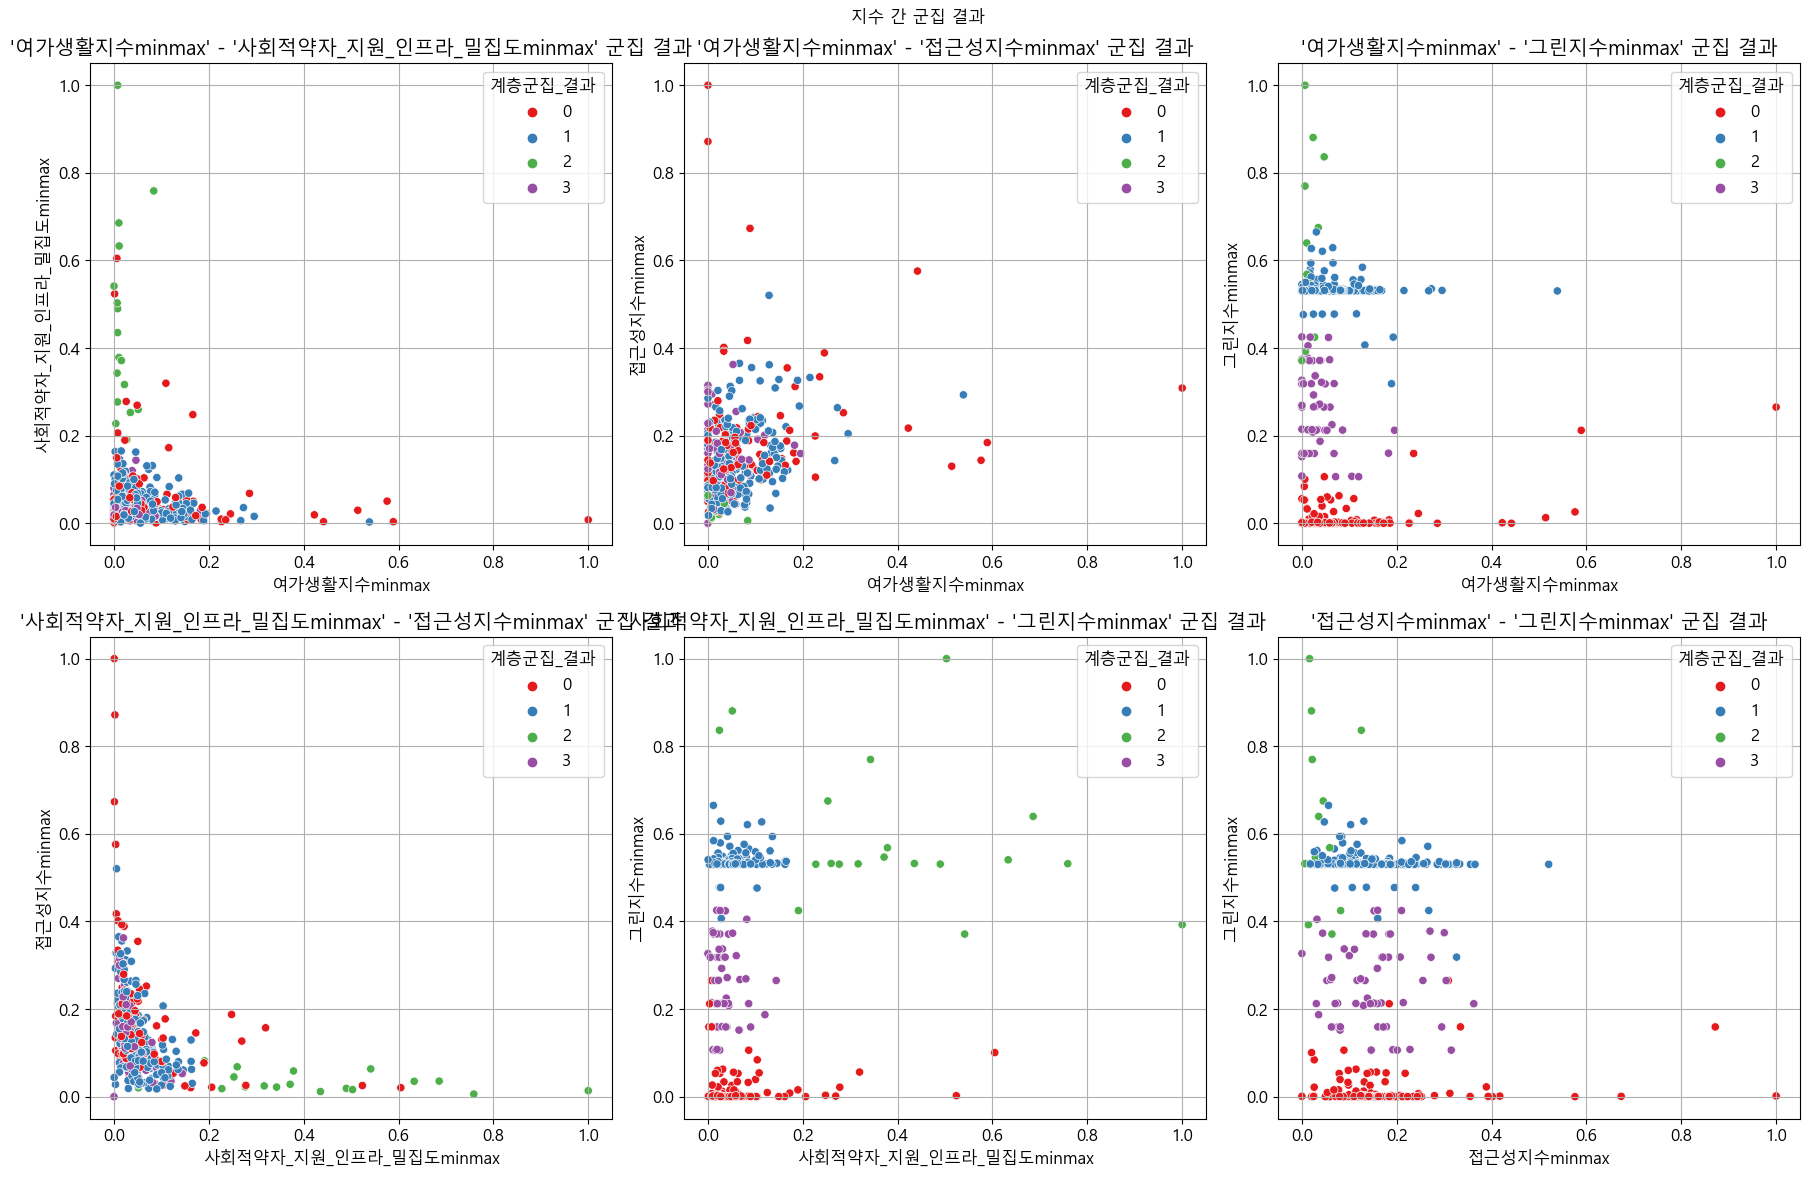

In [21]:
# 2x3 서브플롯을 생성
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("지수 간 군집 결과", fontsize=12)

# 중복되지 않는 조합에 대해서만 그래프를 생성(원래는 3*3으로 전체 )
combinations = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

for i, (index1, index2) in enumerate(combinations, 1):
    # 2x3 서브플롯 중 현재 서브플롯을 선택
    plt.subplot(2, 3, i)
    sb.scatterplot(data=df1, x=사용할지수[index1], y=사용할지수[index2], hue='계층군집_결과', palette='Set1')
    plt.title(f"'{사용할지수[index1]}' - '{사용할지수[index2]}' 군집 결과")
    plt.grid(True)  # 그리드 라인 추가

# 그래프 간 간격 조정
plt.tight_layout()
plt.show()

#### n_clusters=`6`

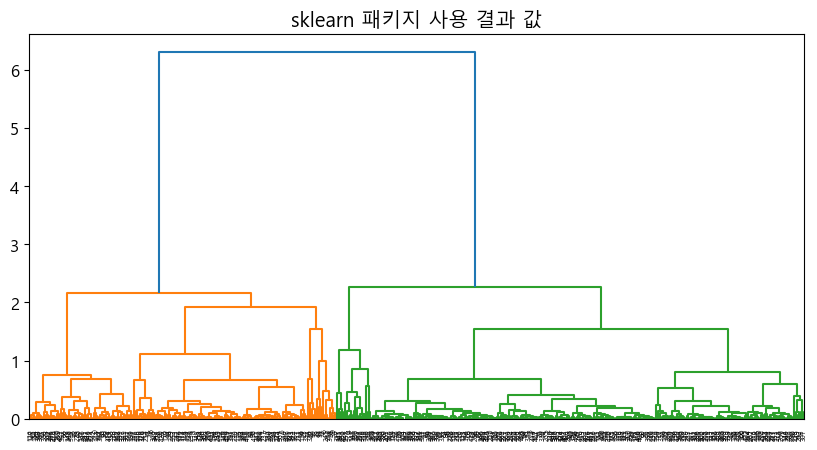

In [22]:
# 모델 객체 생성
ac = AgglomerativeClustering(n_clusters=6,  # 찾아야 할 클러스터 수(earlystopping과 유사)
                             metric='euclidean',  # 클러스터 간 거리 측정 방법
                             linkage='ward',    # 거리측정 방법
                             compute_distances=True #시각화를 위하 반드시 필요
                             )
# clustering2 = ac.fit(X) #학습

clustering2 = ac.fit(ndf) #학습
# print(clustering2.labels_)   #학습결과 확인

# scipy는 아래의 과정을 자동으로 수행, sklearn은 수동으로 설정(공식으로 판단할 것)
counts = np.zeros(clustering2.children_.shape[0])    #zeros 모든 원소가 0인 요소
n_samples = len(clustering2.labels_)

# 자식 노드를 반복하면서 점을 찍어준다(자식이 몇개 있는지 확인하는 과정)
for i, merge in enumerate(clustering2.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# 자식 노드의 수를 저장하는 배열
linkage_matrix = np.column_stack(
    [clustering2.children_, clustering2.distances_, counts]
).astype(float)

# plt를 설정하지 않으면 쓸데 없는 값도 함께 추출됨
# dendrogram(linkage_matrix)

plt.figure(figsize=(10,5))
dendrogram(linkage_matrix)
plt.title("sklearn 패키지 사용 결과 값")
plt.show()
plt.close()

#### 군집수를 `6`으로 설정한 분류 결과값

In [23]:
clustering2.labels_

array([3, 1, 5, 5, 2, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 3, 4, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 3, 0, 4, 1, 1, 1, 1, 1, 1, 5, 0, 0, 5, 5, 5, 1,
       1, 5, 5, 5, 3, 5, 5, 5, 4, 4, 4, 3, 1, 5, 5, 5, 5, 5, 5, 5, 5, 3,
       4, 4, 3, 4, 3, 3, 5, 3, 5, 5, 5, 3, 1, 4, 5, 5, 3, 3, 5, 5, 5, 5,
       5, 3, 4, 5, 5, 5, 5, 2, 5, 4, 5, 3, 3, 4, 3, 5, 5, 5, 5, 3, 5, 5,
       1, 1, 1, 1, 1, 5, 4, 1, 1, 1, 1, 1, 1, 5, 1, 5, 3, 3, 4, 5, 1, 3,
       1, 1, 1, 4, 5, 5, 1, 4, 4, 2, 3, 4, 4, 5, 4, 4, 2, 4, 5, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 2, 3, 5, 3, 4, 2, 1, 2, 4, 1, 5, 1, 5, 3, 5,
       5, 5, 5, 5, 5, 5, 4, 5, 3, 4, 4, 5, 5, 5, 5, 1, 1, 1, 1, 2, 5, 5,
       4, 3, 5, 5, 4, 4, 5, 4, 1, 1, 4, 4, 4, 3, 4, 4, 4, 5, 5, 4, 4, 5,
       5, 2, 5, 5, 3, 1, 5, 1, 1, 1, 1, 1, 1, 3, 1, 5, 5, 1, 5, 5, 5, 3,
       1, 3, 1, 0, 1, 1, 1, 1, 0, 2, 5, 4, 1, 1, 1, 1, 2, 5, 4, 5, 5, 5,
       4, 4, 3, 4, 3, 5, 5, 4, 4, 5, 5, 1, 5, 5, 3, 3, 1, 5, 5, 5, 4, 5,
       5, 4, 2, 3, 5, 4, 4, 4, 5, 4, 4, 3, 4, 5, 4,

In [24]:
unique_labels = list(set(clustering2.labels_))
unique_labels

[0, 1, 2, 3, 4, 5]

##### 분류 결과를 DataFrame과 결합

> 군집(label)을 포함한 DF 생성. <br/> labels를 hue로 잡고 진행하면 군집의 분류 결과를 알 수 있기 때문.

In [25]:
df2 = df.copy()

In [26]:
df2['계층군집_결과'] = clustering2.labels_
df2.head()

,지하철역_수,의료기관_수,사회복지시설_수,행정동별_공원수,공공체육시설_수,문화시설_수,학교_수,사업체_수,하천및한강여부,장애인_인구,세대당공원면적,보육시설수,세대당공원면적minmax,수변점수,행정동별버스정류장수,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,그린지수minmax,계층군집_결과
0,0,11,5,2,10,6,8,992,0,437,337.55,4,0.352898,0,32,0.038298,0.120179,0.035322,0.187151,3
1,2,75,1,3,8,13,2,3532,0,267,60.79,0,0.063554,0,27,0.093504,0.033721,0.131414,0.033704,1
2,0,11,0,1,2,31,2,708,0,110,956.51,3,1.000000,0,16,0.077132,0.078692,0.040614,0.530328,5
3,0,4,4,1,5,5,4,558,유,311,0.00,3,0.000000,10,34,0.024572,0.104086,0.043385,0.530328,5
4,0,15,11,0,5,11,4,747,유,491,1.14,3,0.001192,10,54,0.007649,0.489879,0.018995,0.530960,2


##### 각 지수를 기준으로 군집을 분석한 subplots 생성

In [27]:
X.columns

Index(['여가생활지수minmax', '사회적약자_지원_인프라_밀집도minmax', '접근성지수minmax', '그린지수minmax'], dtype='object')

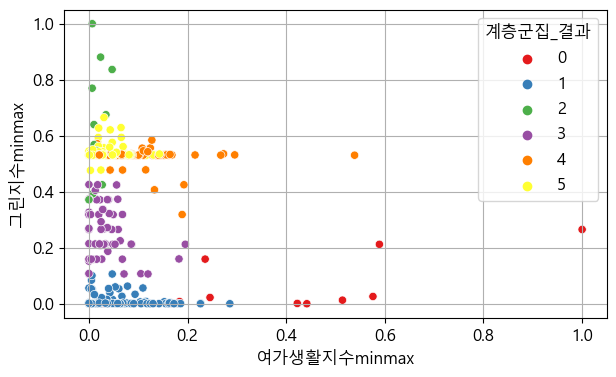

In [31]:
plt.figure(figsize=(7,4))
# #sb.scatterplot(x=X[, 0], y=X[, 1])
sb.scatterplot(data=df2, x='여가생활지수minmax', y='그린지수minmax', hue='계층군집_결과', palette='Set1')
plt.grid()
plt.show()
plt.close()

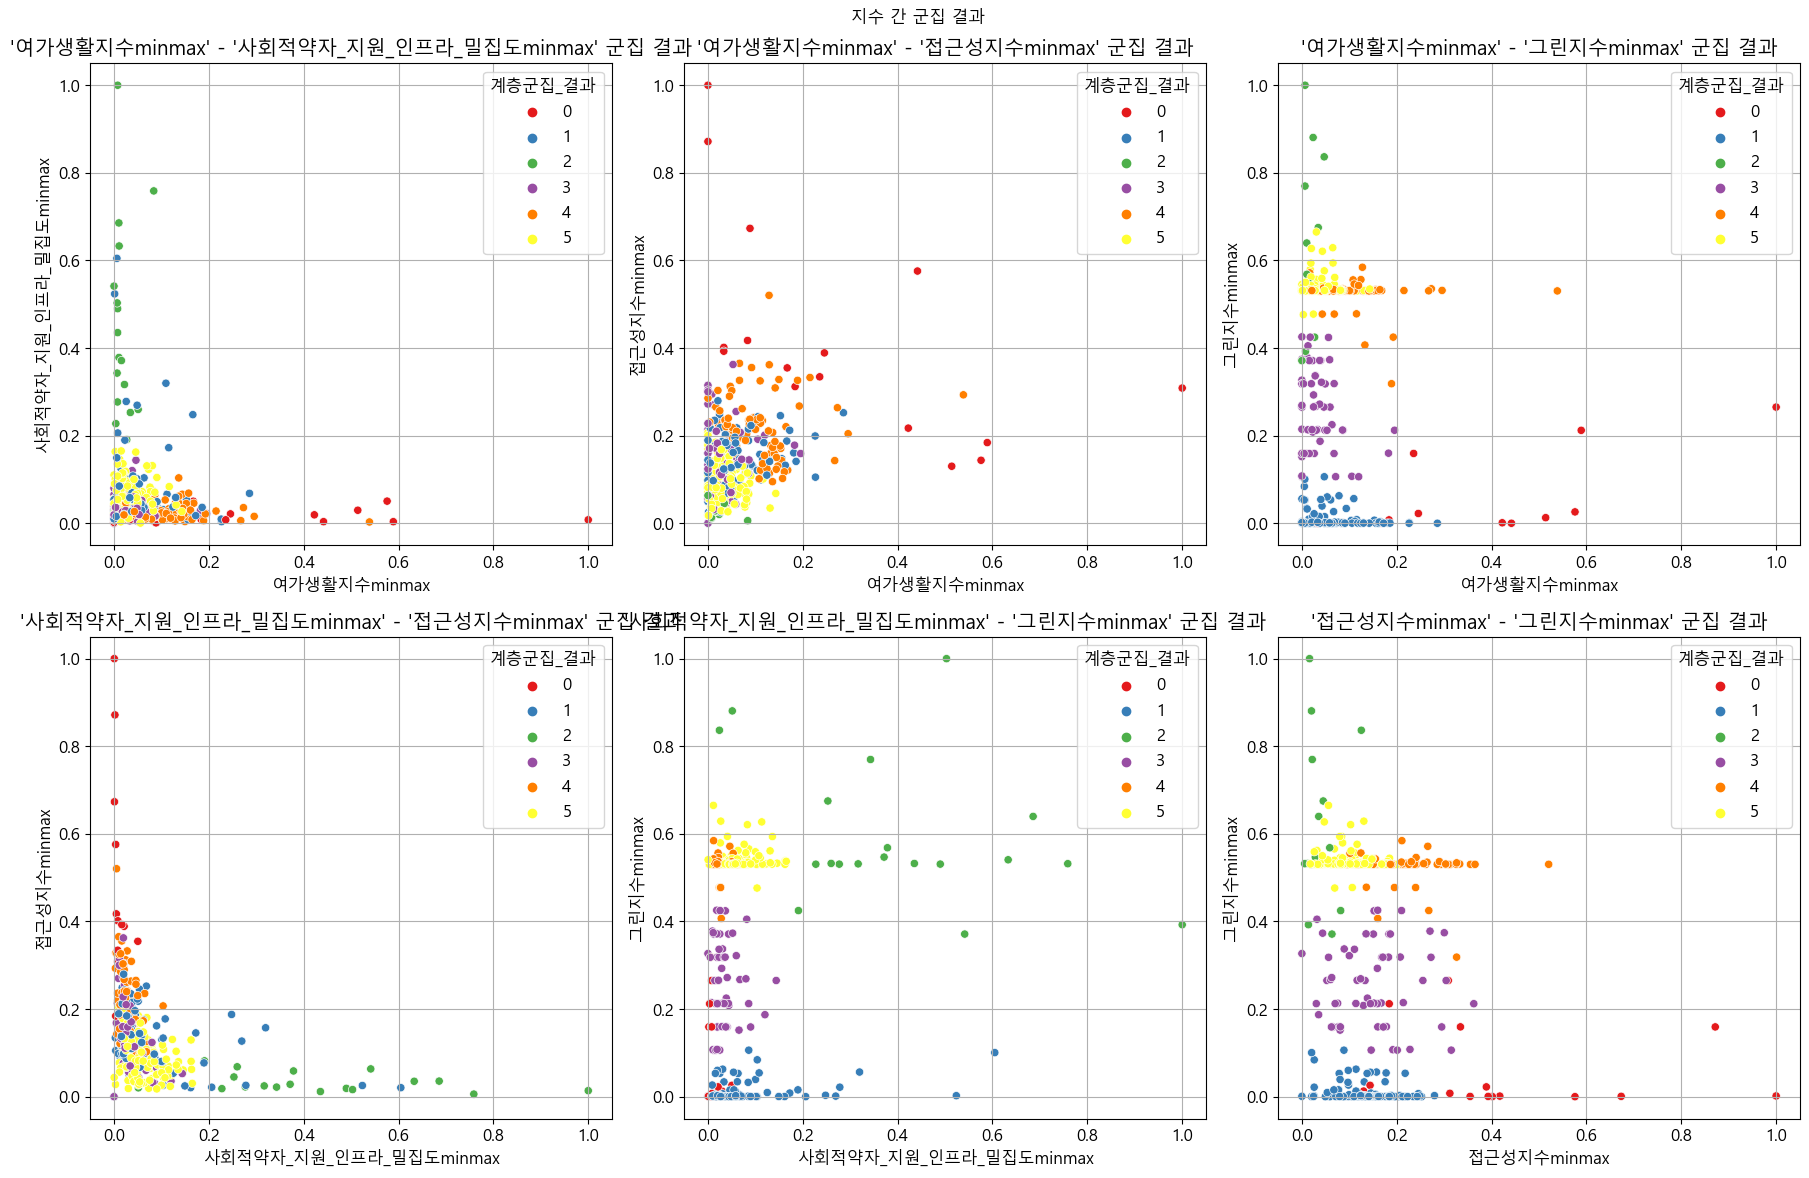

In [29]:
# 2x3 서브플롯을 생성
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("지수 간 군집 결과", fontsize=12)

# 중복되지 않는 조합에 대해서만 그래프를 생성
combinations = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

for i, (index1, index2) in enumerate(combinations, 1):
    # 2x3 서브플롯 중 현재 서브플롯을 선택
    plt.subplot(2, 3, i)
    sb.scatterplot(data=df2, x=사용할지수[index1], y=사용할지수[index2], hue='계층군집_결과', palette='Set1')
    plt.title(f"'{사용할지수[index1]}' - '{사용할지수[index2]}' 군집 결과")
    plt.grid(True)  # 그리드 라인 추가

# 그래프 간 간격 조정
plt.tight_layout()
plt.show()